# Hierarchical Clustering

This notebook applies hierarchical clustering to the dataset using Ward linkage, using the dendrogram to select a distance threshold and evaluating cluster quality via silhouette scores before interpreting the results through PCA visualisation and feature importance.

In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import Huber
import tensorflow as tf
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier


np.random.seed(22)
random.seed(22)
tf.random.set_seed(22)

df = pd.read_csv('../datasets/all_numerical_only_indie.csv', index_col='name')
df = df.drop(columns=['indie'])

## Train/Test Split and Scaling

The data is split 80/20, then scaled using MinMaxScaler fitted only on the training set to avoid data leakage.

In [13]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=22)

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Hierarchical Clustering

Ward linkage is used to build the hierarchy — it minimises the total within-cluster variance at each merge step, which tends to produce compact, evenly-sized clusters.

In [14]:
linked = linkage(X_train_scaled, method='ward')

### Dendrogram

Plotting the full dendrogram without labels (too many data points to label usefully). A horizontal cut at Euclidean distance = 4 is drawn to visually indicate where clusters are defined.

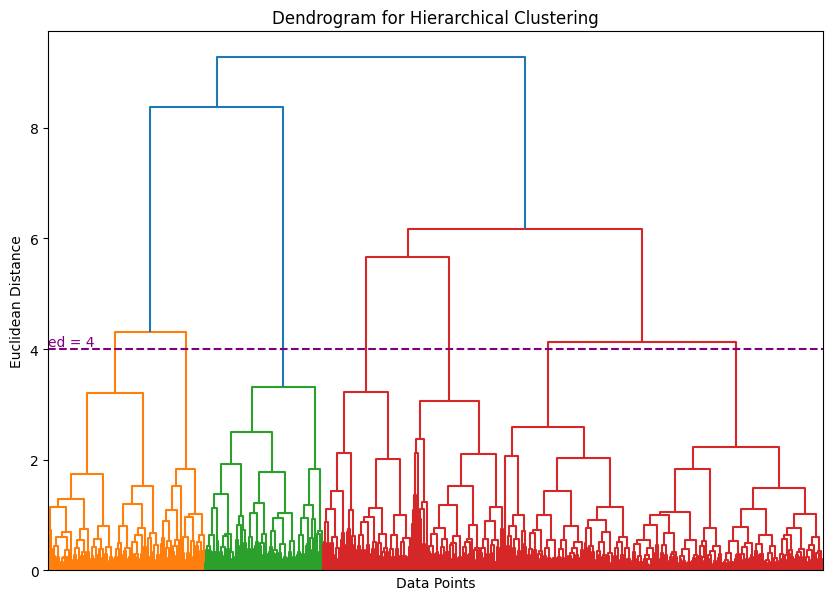

In [15]:
plt.figure(figsize=(10, 7))
# dendrogram(linked, labels=X_train_scaled.index, orientation='top', distance_sort='descending',)
dendrogram(linked, no_labels = True, orientation='top', distance_sort='descending',)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.axhline(y=4, linestyle='--', color='purple')
plt.text(x=0, y=4, s="ed = 4", color="purple", fontsize=10, verticalalignment='bottom')
plt.savefig('../graphs/dendogramlarge.png', dpi=300, bbox_inches='tight')
plt.show()

### Cutting the Dendrogram

Clusters are formed by cutting at `distance_threshold = 4`, which was chosen by inspecting the dendrogram for a clear gap in merge distances.

In [16]:
distance_threshold = 4

cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')

X_train_scaled['Cluster'] = cluster_labels

print(X_train_scaled.head())

      score  user score   critics     users     price  dlc_count  \
0  0.727273    0.584416  0.521739  0.056986  0.333222      0.010   
1  0.969697    0.948052  0.597826  0.118220  0.333222      0.000   
2  0.484848    0.519481  0.076087  0.000354  0.166528      0.005   
3  0.681818    0.805195  0.413043  0.008229  0.333222      0.000   
4  0.848485    0.753247  0.195652  0.008849  0.000000      0.020   

   achievements  average_playtime_forever  average_playtime_2weeks  \
0      0.000000                  0.031305                 0.000000   
1      0.000000                  0.034064                 0.000000   
2      0.000000                  0.000000                 0.000000   
3      0.071932                  0.010708                 0.000000   
4      0.000000                  0.022304                 0.017579   

   total_steam_reviews  percent_positive_steam  release_date_numeric  Cluster  
0             0.007971                0.302071              0.627061        2  
1         

### Silhouette Score Sweep

Sweeping across distance thresholds 3–8 to evaluate cluster quality. The silhouette score measures how similar a point is to its own cluster vs neighbouring clusters — higher is better, with 1 being ideal.

   Max_Distance  Silhouette_Score
0             3          0.480633
1             4          0.650176
2             5          0.575366
3             6          0.594266
4             7          0.500311
5             8          0.500311


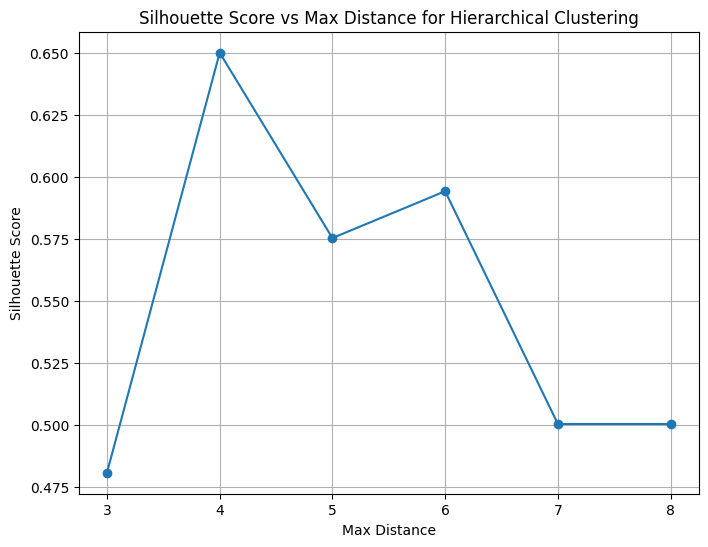

In [17]:
results = []
# Test different max_d values (or number of clusters) for silhouette score
for max_d in range(3, 9):
    clusters = fcluster(linked, max_d, criterion='distance')
    sil_score = silhouette_score(X_train_scaled, clusters)
    results.append((max_d, sil_score))

results_df = pd.DataFrame(results, columns=["Max_Distance", "Silhouette_Score"])

print(results_df)

plt.figure(figsize=(8, 6))
plt.plot(results_df["Max_Distance"], results_df["Silhouette_Score"], marker='o')
plt.title("Silhouette Score vs Max Distance for Hierarchical Clustering")
plt.xlabel("Max Distance")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.savefig('../graphs/silhoutte_hierarchical')
plt.show()

In [18]:
# from sklearn.decomposition import PCA

# # Apply PCA to reduce the dimensionality to 2D for visualization
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train_scaled.drop('Cluster', axis=1))

# # Create a scatter plot of the first two PCA components, colored by cluster label
# plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_train_scaled['Cluster'], cmap='viridis', s=50, alpha=0.7)
# plt.title('Cluster Visualization in 2D (PCA)')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

### Cluster Visualisation (PCA)

Dimensionality reduced to 2D via PCA for visualisation. Each cluster is given a distinct colour from the tab10 palette.

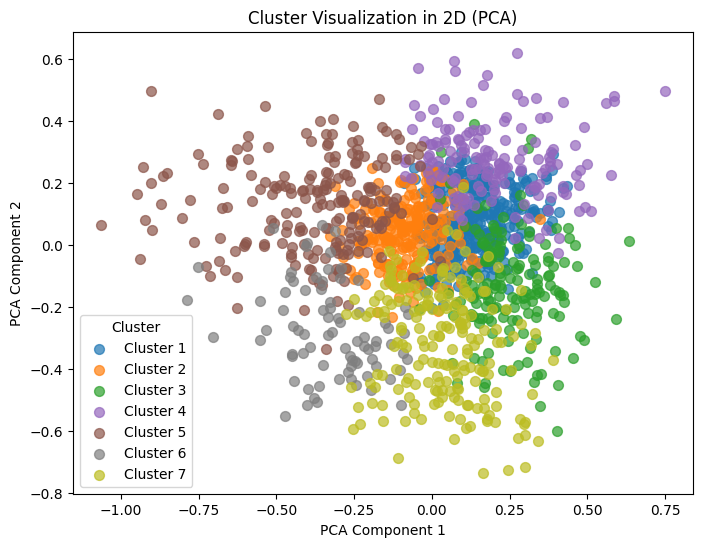

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled.drop('Cluster', axis=1))

unique_clusters = sorted(X_train_scaled['Cluster'].unique())

colormap = matplotlib.colormaps['tab10']  # Use 'tab10' colormap for discrete colors

plt.figure(figsize=(8, 6))
for i, cluster in enumerate(unique_clusters):
    cluster_data = X_pca[X_train_scaled['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', color=colormap(i / len(unique_clusters)), s=50, alpha=0.7)

plt.title('Cluster Visualization in 2D (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.legend(title='Cluster')
plt.savefig(f'../graphs/Hierarchical Clustering Visualisation PCA ED={distance_threshold}.png', dpi=300, bbox_inches='tight')
plt.show()

### Sampled Dendrogram

A dendrogram on 100 randomly sampled points — makes the tree readable with individual data point labels visible.

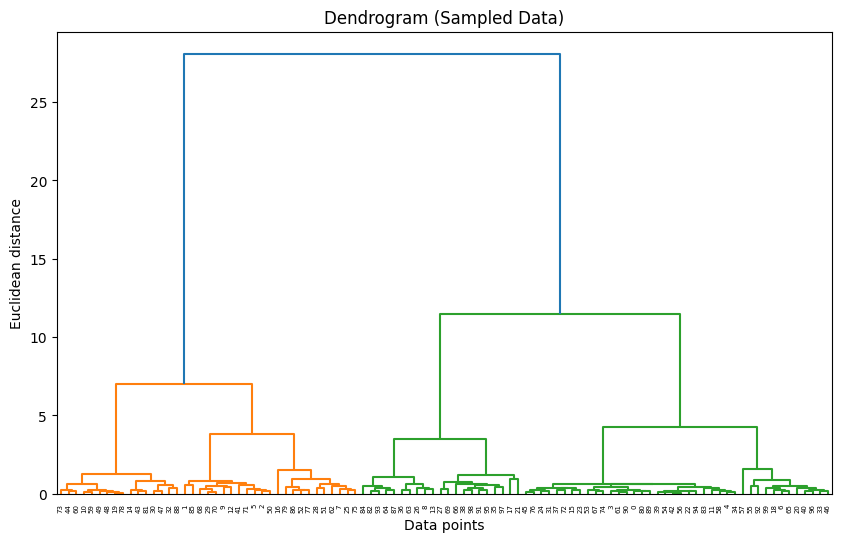

In [20]:
#Example of sampling a smaller subset of the data (e.g., 100 rows)
X_train_scaled_sampled = X_train_scaled.sample(n=100, random_state=22)

# Perform hierarchical clustering on the sampled data
linked = linkage(X_train_scaled_sampled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Dendrogram (Sampled Data)')
plt.xlabel('Data points')
plt.ylabel('Euclidean distance')
plt.savefig(f'../graphs/Dendrogram Sampled ED={distance_threshold}.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

A Random Forest classifier is trained to predict cluster membership from the original features. The resulting feature importances indicate which variables are most informative for distinguishing the clusters.

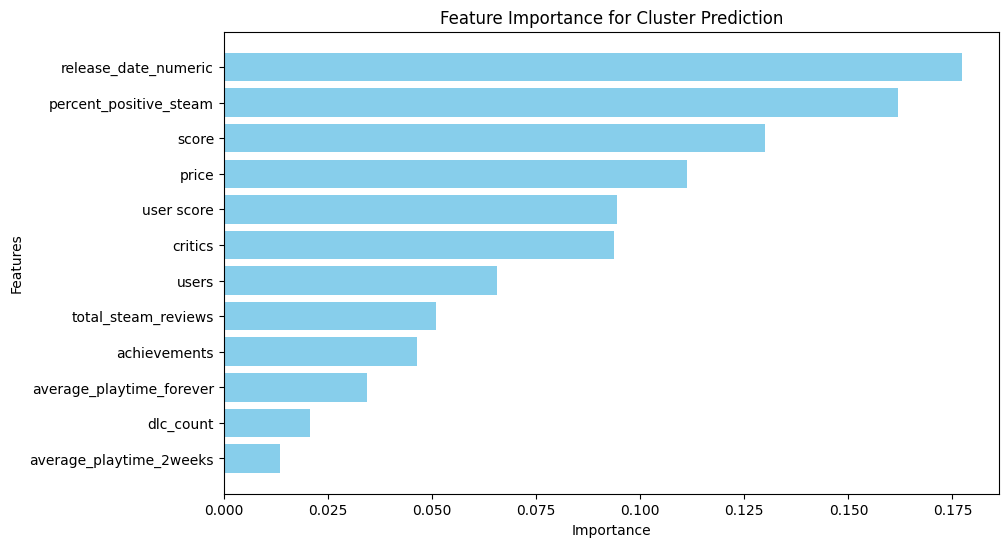

In [21]:
X = X_train_scaled.drop(columns='Cluster')  # Features (original data, without the cluster column)
y = X_train_scaled['Cluster'] 

rf = RandomForestClassifier(n_estimators=100, random_state=22)

rf.fit(X, y)

feature_importances = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Cluster Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig(f'../graphs/Feature Importance Hierarchical ED={distance_threshold}.png', dpi=300, bbox_inches='tight')
plt.show()

### Pairplot - All Clusters

Pairplot of the original features coloured by cluster label. KDE on the diagonal gives a sense of the distribution within each cluster.

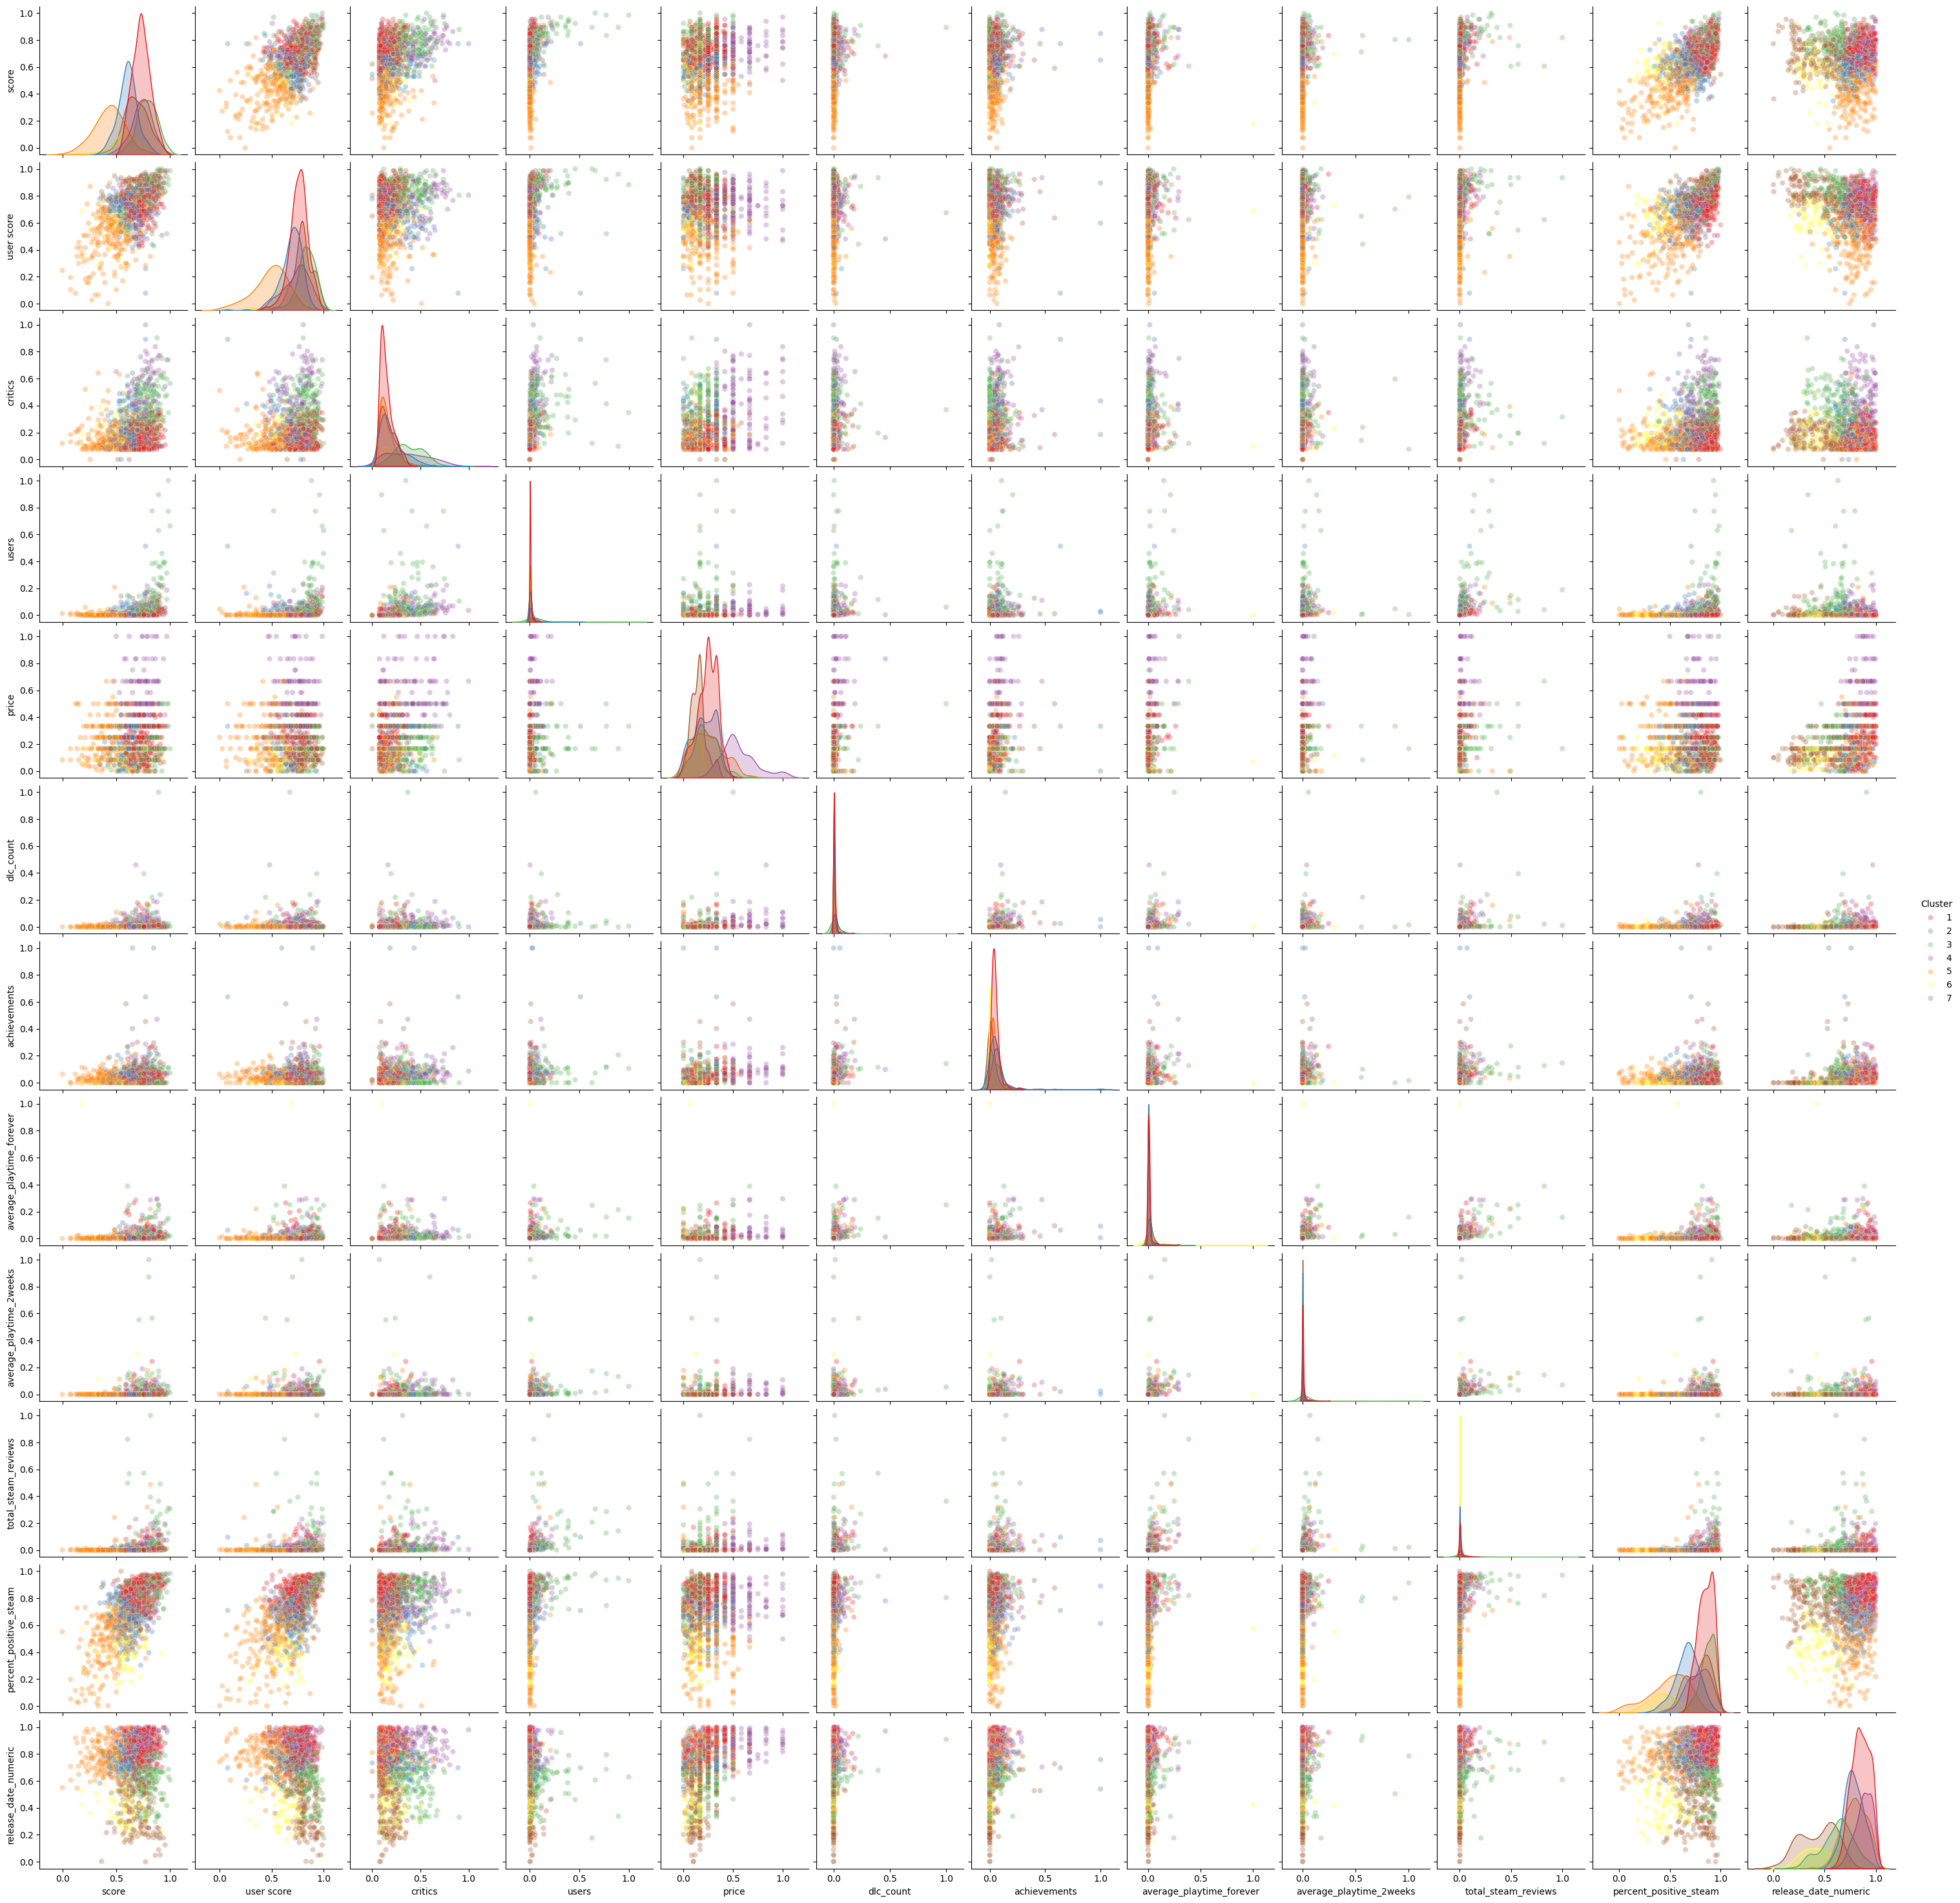

In [22]:
sns.pairplot(X_train_scaled, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
plt.title("")
plt.savefig('../graphs/Clusters vs original features (hierarchical, no genres).png', dpi=300, bbox_inches='tight')
plt.show()

### Pairplot - Clusters 1 and 2 Only

Filtered down to the two most similar clusters for a cleaner comparison

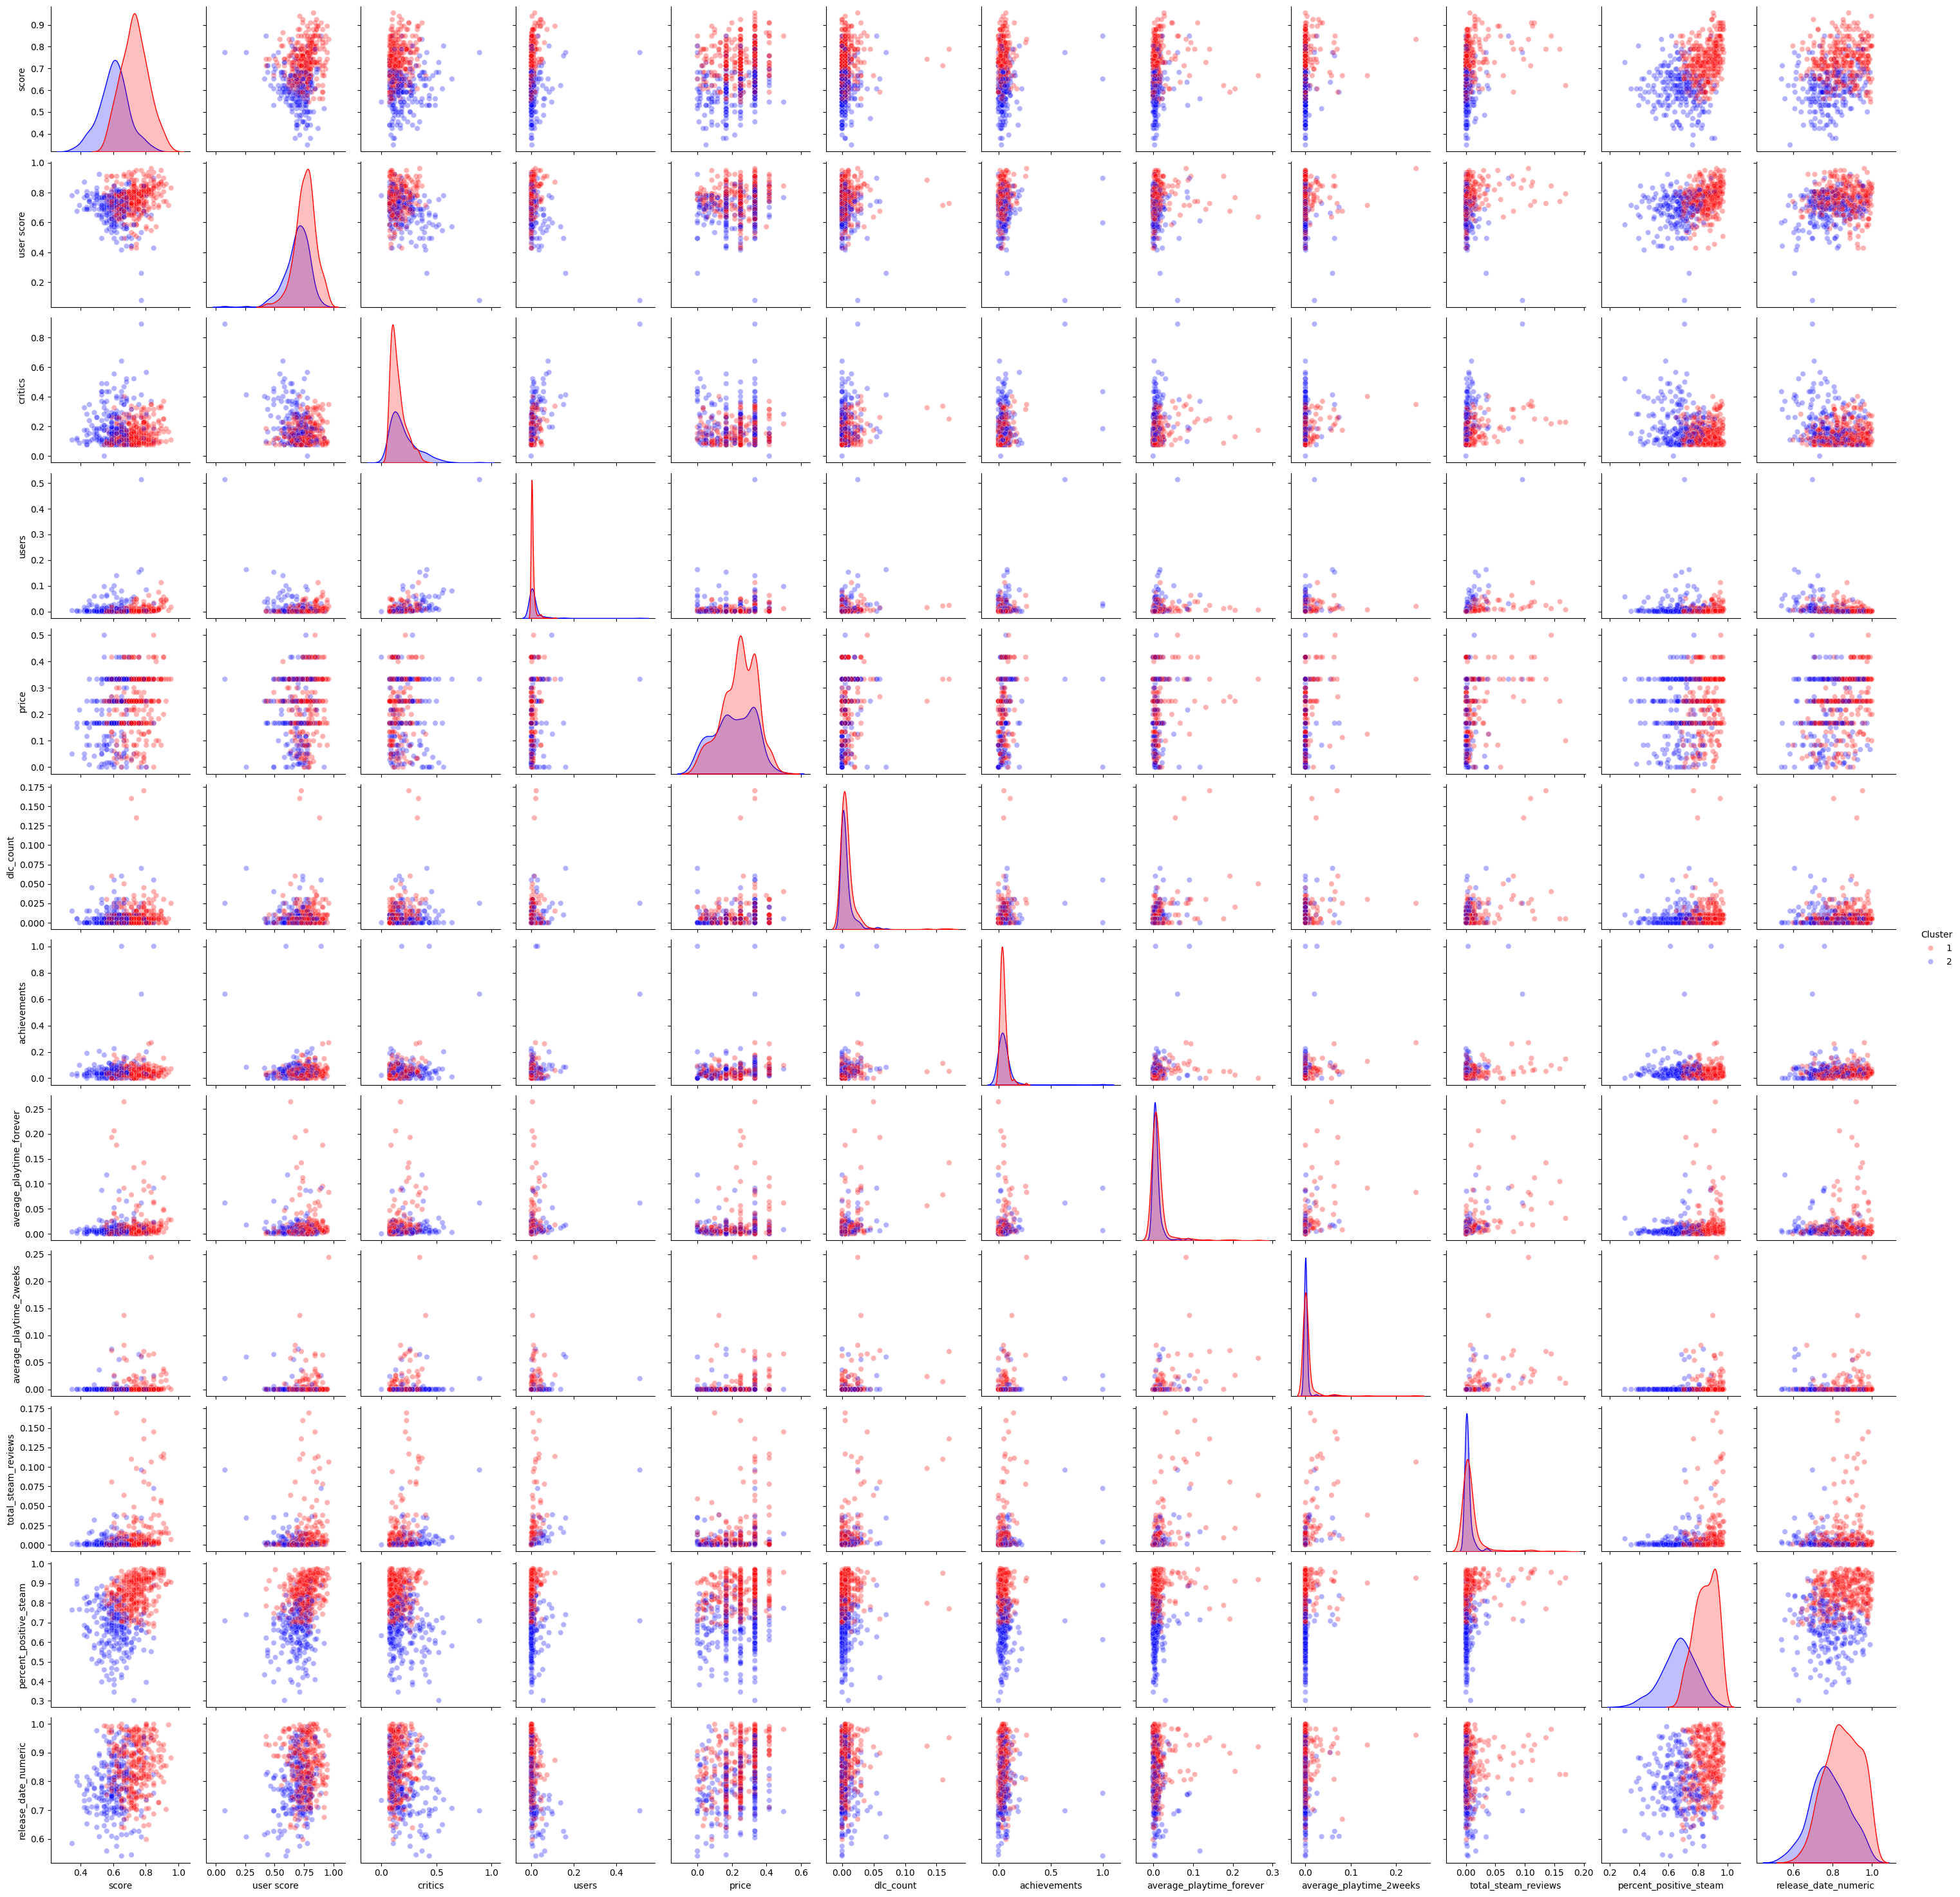

In [23]:
# Select only the clusters you want (red and blue)
filtered_df = X_train_scaled[X_train_scaled['Cluster'].isin([1, 2])]
# Create the pairplot with just red and blue clusters
sns.pairplot(filtered_df, hue='Cluster', palette={1: "red", 2: "blue"}, diag_kind='kde', plot_kws={'alpha': 0.3})
# Save and show the plot
plt.savefig('../graphs/RB_only_Filtered_Clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
n_clusters = len(np.unique(cluster_labels))
centroids = np.array([
    X_train_scaled.drop(columns='Cluster')[cluster_labels == c].mean(axis=0)
    for c in np.unique(cluster_labels)
])

test_cluster_labels = np.array([
    np.argmin(np.linalg.norm(centroids - row, axis=1))
    for row in X_test_scaled.drop(columns='Cluster', errors='ignore').values
])
X_test_scaled['Cluster'] = test_cluster_labels + 1

full_data = pd.concat([X_train_scaled, X_test_scaled])
full_data.index = list(X_train.index) + list(X_test.index)
full_data.to_csv('../datasets/clustered_data.csv', index_label='name')
print(f"Exported {len(full_data)} games across {full_data['Cluster'].nunique()} clusters")

Exported 1715 games across 7 clusters


In [33]:
# check = pd.read_csv('../datasets/clustered_data.csv', index_col='name')
# print(check.shape)
# print(check['Cluster'].value_counts().sort_index())

In [34]:
# print(check.columns.tolist())